In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torchvision.transforms import ToTensor, ToPILImage

In [2]:
# Set random seed for reproducibility
#manualSeed = 999
manualSeed = random.randint(1, 10000)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

# Set Config

In [3]:
class Config(object):
    
    # Root directory for dataset
    cwd = os.getcwd()
    dataroot = cwd + "/dataset"
    print(dataroot)
    
    # Number of workers for dataloader
    workers = 2
    
    # Spatial size of training images. All images will be resized to this
    # size using a transformer.
    image_size = 64

    # Batch size during training
    batch_size = 256
    
    # Learning rate for optimizers
    lr = 0.0002
    
    # Beta1 hyperparam for Adam optimizers
    beta1 = 0.5
    
    # Number of channels in the training images. For color images this is 3
    nc = 3

    # Size of z latent vector (i.e. size of generator input)
    nz = 100

    # Size of feature maps in generator
    ngf = 64

    # Size of feature maps in discriminator
    ndf = 64
    
    # Number of training epochs
    num_epochs = 50
    
    # Number of GPUs available. Use 0 for CPU mode.
    ngpu = 1
    
opt = Config()

/home/hsuchaochun/dataScience2020/hw/4/dataset


In [4]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=opt.dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(opt.image_size),
                               transforms.CenterCrop(opt.image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt.batch_size,
                                         shuffle=True, num_workers=opt.workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and opt.ngpu > 0) else "cpu")

# Plot training images

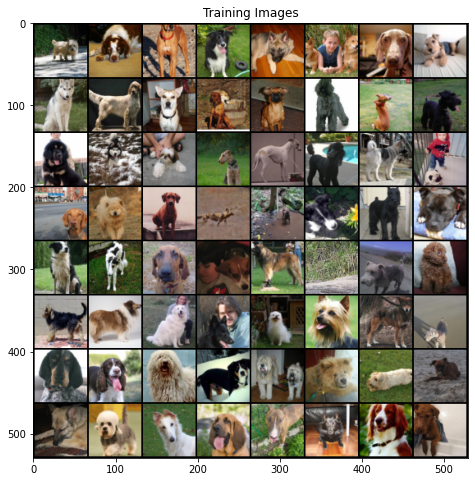

In [5]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("on")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

# Create Network

In [6]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(opt.nz, opt.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(opt.ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(opt.ngf * 8, opt.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(opt.ngf * 4, opt.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(opt.ngf * 2, opt.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(opt.ngf, opt.nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = opt.ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(opt.nc, opt.ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(opt.ndf, opt.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(opt.ndf * 2, opt.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(opt.ndf * 4, opt.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(opt.ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(opt.ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
netG = Generator(opt.ngpu).to(device)
netD = Discriminator(opt.ngpu).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (opt.ngpu > 1):
#    netD = nn.DataParallel(netD, list(range(opt.ngpu)))
#if (device.type == 'cuda') and (opt.ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)
netD.apply(weights_init)

# Print the model
print(netG)
print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [10]:
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))

# Initialize BCELoss function
criterion = nn.BCELoss().to(device)

# Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(opt.batch_size, opt.nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0



# Training Loop

In [11]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
cwd = os.getcwd()

print("Starting Training Loop...")
# For each epoch
for epoch in range(opt.num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # errD_real = errD_real.to(torch.float32)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, opt.nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, opt.num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            # vutils.save_image(fake.detach(), cwd + "/result/process.png",normalize=True)
            vutils.save_image(fake.detach(), cwd + "/result/process.png", normalize=True)
            
            #if errG.item() <= 1.3 and errD.item() <= 0.7:
            if 1:
                vutils.save_image(fake.detach(), cwd + "/result/images/%s_%4f.png" 
                                  % (epoch, errG.item()), normalize=True)
                torch.save(netD.state_dict(), cwd + "/result/model/netD_%s_%4f.pth " 
                           % (epoch, errG.item()))
                torch.save(netG.state_dict(), cwd + "/result/model/netG_%s_%4f.pth " 
                           % (epoch, errG.item()))
        

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
       

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == opt.num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
            
        iters += 1




Starting Training Loop...
[0/50][0/81]	Loss_D: 1.6662	Loss_G: 5.7800	D(x): 0.5094	D(G(z)): 0.5116 / 0.0056


FileNotFoundError: [Errno 2] No such file or directory: '/home/hsuchaochun/dataScience2020/hw/4/result/images/0_5.780003.png'

## Plot Result

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Generate Images

In [ ]:
cwd = os.getcwd()
map_location = lambda storage, loc: storage
netD.load_state_dict(torch.load( cwd + "/result/model/netD_37_0.487621.pth " , map_location=map_location))
netG.load_state_dict(torch.load( cwd + "/result/model/netG_37_0.487621.pth " , map_location=map_location))
netD.to(device)
netG.to(device)

for ii in range(1,50001):
    
    result = []
    
    # Generate batch of latent vectors
    noise = torch.randn(256, opt.nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)

    #num = random.randint(0, 255)
    result.append(fake.data[128])
   
    vutils.save_image(torch.stack(result), cwd + "/Generate_imgs/%d.png" % (ii), normalize=True, range=(-1, 1))

In [ ]:
##(3,64,64) to (3,32,32)
cwd = os.getcwd()
for i in range(1,50001):
    img = cv2.imread( cwd + "/Generate_imgs/%s.png" %(i))
    #print('Original Dimensions : ',img.shape)
    resized = cv2.resize(img, (32,32), interpolation = cv2.INTER_AREA)
    #print('Resized Dimensions : ',resized.shape)
    cv2.imwrite( cwd + "/Generate_imgs/%s.png" %(i), resized)

In [ ]:
## Inception_score
%run ./tf_inception_score.py Generate_imgs